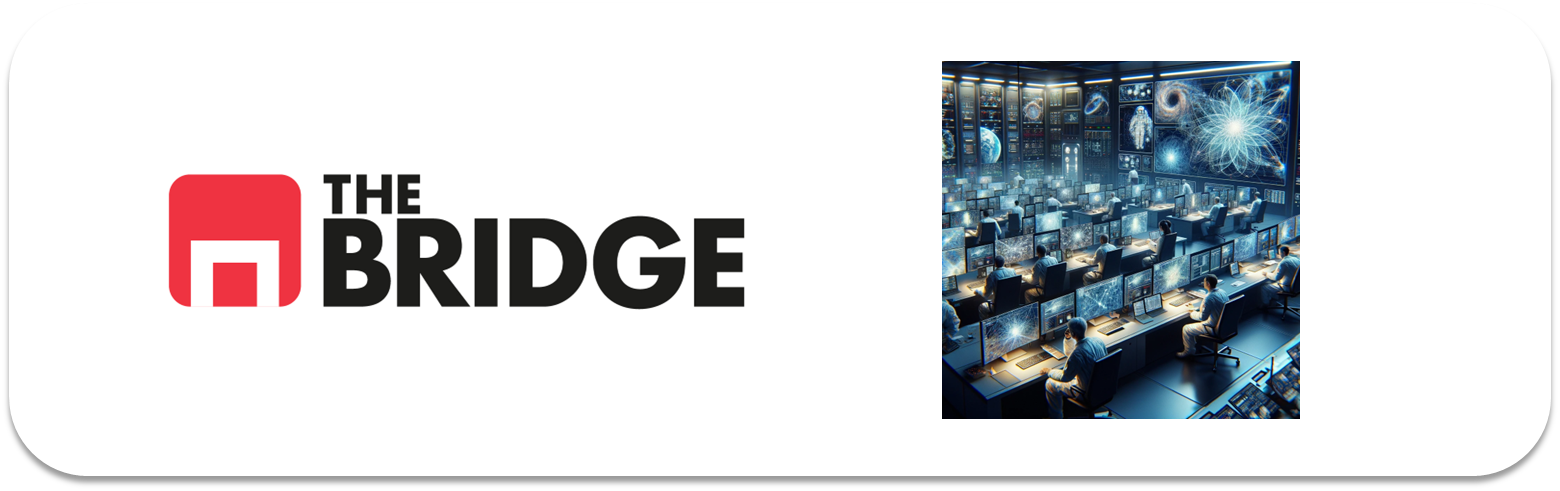

## PRACTICA OBLIGATORIA: **Redes Convolucionales**

* La práctica obligatoria de esta unidad consiste en un ejercicio de construcción de una red convolucional con Keras para la clasificación de imagenes de simpáticos perretes y gatetes. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import viztools as viz
import os

from skimage.io import imread
from sklearn.utils import shuffle

import keras
import cv2

2024-10-24 16:17:04.480293: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Problema de Negocio y dataset

Una conocida empresa de información inmobiliaria utiliza un CAPTCHA visual de perros y gatos para detectar webscrappings intensivos y ataques de denegación de servicio. Últimamente, ha detectado que su sistema está empezando a flojear, es decir que hay muchos sistemas de detección automática de imágenes que son capaces de detectar que es un perro y un gato y salterse el CAPTCHA antirobots. Por eso nos ha pedido que entrenemos un modelo potente de clasificación que emule a estos sistemas con el objetivo de emplear como fotografías para el CAPTCHA aquellas que no sepa detectar este sistema emulador de chicos malos.  

Pues manos a la obra, tenemos que seleccionar en un conjunto de 1000 imágenes aquellas que peor se le daría clasificar a un potencial sistema anti-CAPTCHA.  

Para ello vamos a emplear un conjunto de train de 4000 imágenes de perretes y gatetes que se encuentran distribuidas en "data" en cuatro directorios "github_train_0",  "github_train_1", "githun_train_2" y "github_train_3". Los datos de las imagenes que tenemos que clasificar y luego seleccionar como las más "difíciles" están en "data" en el directorio "github_test".


### Se pide

1. Crear los datasets X,y de train y test, leyendo las imágenes de los directorios correspondientes (tendrás que leer todas las imágenes de los cuatro directorios para train) y a la vez que se leen adpatar su resolución para que todas tengan un tamaño de 32x32. En este caso puedes adaptar las funciones de los ejercicios de la unidad. NOTA: Ten en cuenta que la clase a la que pertenece en la foto está en el nombre del archivo.

2. Crea un modelo DL basado en redes convolucionales con al menos dos juegos Convolucional-Pooling. Sigue todo el proceso de ML (visualización del dataset, MiniEDA, Construcción del modelo)

3. Entrenar el modelo con un callback de Earlystopping con paciencia la que tengas :-). Muestra su historial de entrenamiento.

4. Evalua el modelo, haz un reporte de clasificacion y muestra la matriz de confianza.

5. Es el momento de seleccionar las imagenes: Selecciona el 10% de imágenes mal clasificadas de una y otra clase que tengan el mayor nivel de confianza de que pertenencían a la clase errónea. Es decir las imágenes de perros clasificadas como gatos y con la probabilidad de ser perror más alta.


### Extra (para hacer en clase)

Repite los pasos 3 a 5 utilizando el generador de imágenes sintéticas o Image Augmentation de Keras. 



---
1. Crear los datasets X,y de train y test, leyendo las imágenes de los directorios correspondientes (tendrás que leer todas las imágenes de los cuatro directorios para train) y a la vez que se leen adpatar su resolución para que todas tengan un tamaño de 32x32. En este caso puedes adaptar las funciones de los ejercicios de la unidad. NOTA: Ten en cuenta que la clase a la que pertenece en la foto está en el nombre del archivo.

In [2]:
import zipfile

In [3]:
zip_files = ['github_test.zip','github_train_0.zip','github_train_1.zip','gitHUb_train_2.zip','github_train_3.zip']
directory_to_extract_to = "./data/"

for zip_file in zip_files:
    with zipfile.ZipFile(f'./data/{zip_file}', 'r') as zip_ref:
        zip_ref.extractall(directory_to_extract_to)

In [4]:
def read_data(directory, reshape_dim = (32,32)):
    X = []
    y = []
    for file in os.listdir(directory):
        file_path = os.path.join(directory, file)
        if os.path.isfile(file_path):
                image = imread(file_path)
                image = cv2.resize(image, reshape_dim)
                X.append(image)
                label = file.split('.')[0]
                y.append(label)

    return np.array(X), np.array(y)

Read images for each folder

In [5]:
X0, y0 = read_data('./data/github_train_0')
X1, y1 = read_data('./data/github_train_1')
X2, y2 = read_data('./data/github_train_2')
X3, y3 = read_data('./data/github_train_3')

Concatenate into 1 X, y pair for train

In [6]:
X_train = np.concatenate([X0, X1, X2, X3], axis=0)
y_train = np.concatenate([y0, y1, y2, y3], axis=0)

Chck shape of X_train, y_train arrays

In [7]:
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')

X_train shape: (4000, 32, 32, 3)
y_train shape: (4000,)


Create X_test, y_test

In [8]:
X_test, y_test = read_data('./data/github_test')

Map target classes to numbers for training/testing of model

In [22]:
y_map = {'cat':0, 'dog':1}
y_train_num = np.array([y_map[y] for y in y_train])
y_test_num = np.array([y_map[y] for y in y_test])

Use function to view some images from X_train

In [9]:
def show_image_batch(images, names = [], cmap = None, n_cols = 5, size_scale = 2):
    n_rows = ((len(images) - 1) // n_cols + 1)
    plt.figure(figsize=(n_cols * size_scale, n_rows * 1.1*size_scale))

    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap = cmap)
        plt.axis("off")

        if len(names):
            plt.title(names[index])
    
    plt.show()

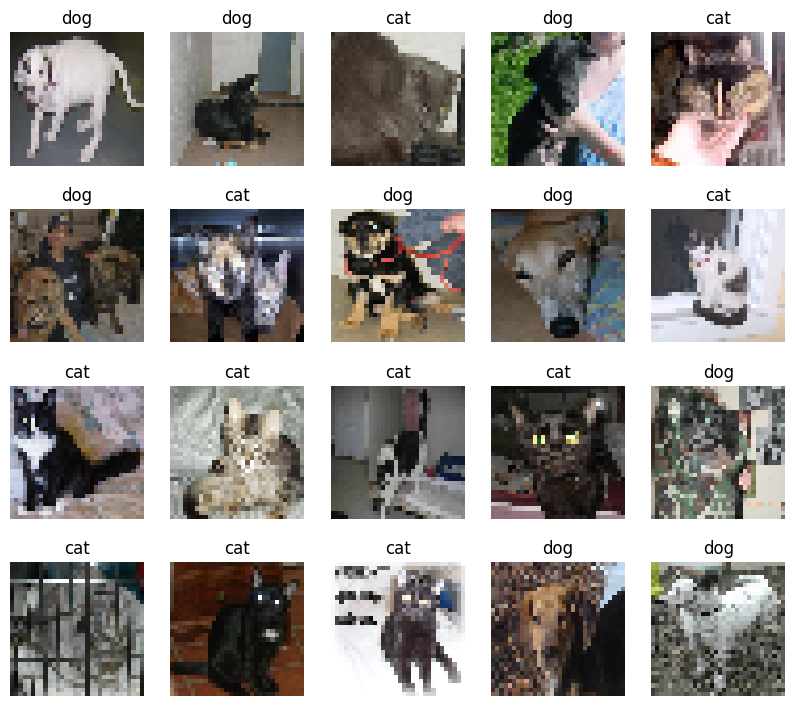

In [10]:
rand_indices = np.random.randint(0, len(X_train), 20)
show_image_batch(X_train[rand_indices], names=y_train[rand_indices])

Convert y_train to a dataframe for visualizing distribution

In [11]:
targets = pd.DataFrame(y_train, columns=['target'])

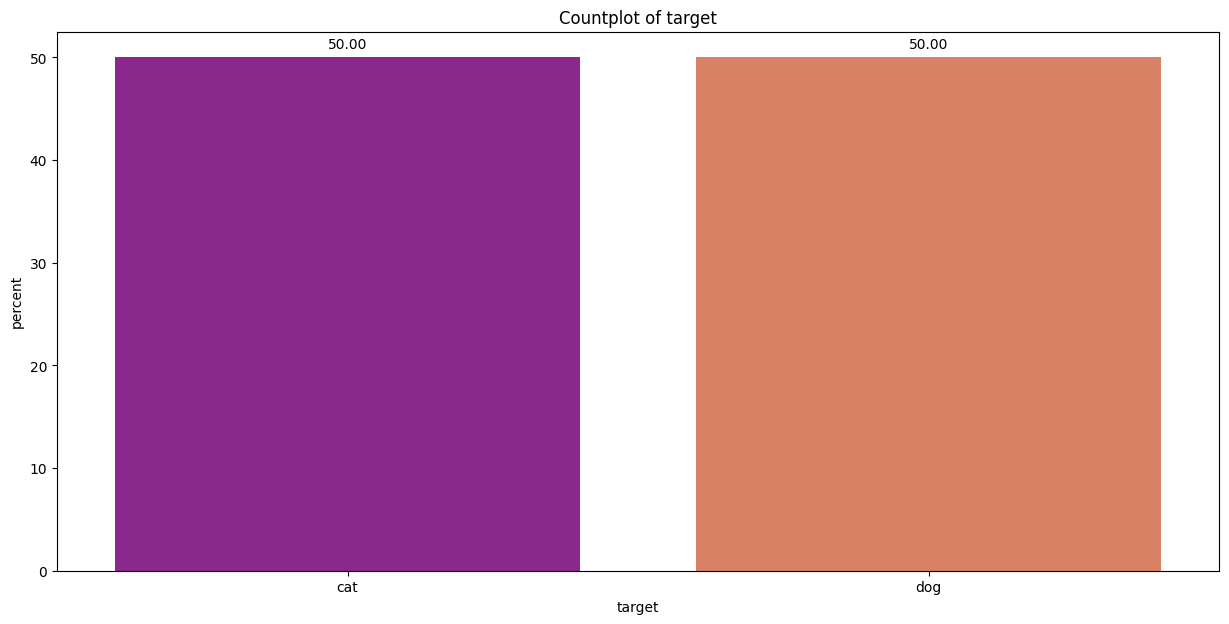

In [12]:
viz.countplot(targets, 'target', stat='percent', show_vals=True)

Nicely balanced

Make it all into a dataframe, although i dont think this is strictly necessary

In [13]:
train_df = X_train.copy()

In [14]:
train_df = train_df.reshape(train_df.shape[0], -1)

In [15]:
train_df = pd.DataFrame(train_df)
train_df['target'] = targets['target']

In [16]:
train_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,3062,3063,3064,3065,3066,3067,3068,3069,3070,3071
count,4000.000000,4000.00000,4000.000000,4000.000000,4000.000000,4000.000000,4000.00000,4000.000000,4000.000000,4000.000000,...,4000.000000,4000.00000,4000.000000,4000.000000,4000.00000,4000.000000,4000.000000,4000.00000,4000.000000,4000.000000
mean,119.618000,114.82150,106.223000,120.654000,115.415750,106.633500,121.47200,116.412500,107.354500,122.437500,...,115.695500,130.49100,123.153750,114.219750,129.43150,122.414250,113.775000,127.22175,120.713500,112.486000
std,70.543374,70.08522,71.254095,69.964441,69.504199,70.917593,69.38348,69.035845,71.038971,69.715225,...,68.005305,67.12169,65.963933,68.322005,67.87007,66.733125,68.805115,67.62556,66.813864,68.970595
min,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,61.000000,55.75000,46.000000,62.000000,56.000000,47.000000,65.00000,59.000000,47.000000,66.000000,...,60.000000,78.75000,72.000000,58.000000,77.00000,71.000000,57.000000,74.00000,68.000000,56.000000
50%,115.000000,110.00000,97.000000,118.000000,111.000000,98.000000,119.00000,111.000000,99.000000,119.000000,...,110.000000,131.50000,121.000000,108.000000,130.00000,121.000000,107.500000,127.00000,118.000000,106.000000
75%,172.000000,166.00000,156.000000,174.000000,167.000000,158.000000,173.00000,167.000000,158.000000,174.000000,...,166.000000,182.00000,171.000000,165.000000,181.00000,170.000000,165.000000,177.25000,169.000000,162.000000
max,255.000000,255.00000,255.000000,255.000000,255.000000,255.000000,255.00000,255.000000,255.000000,255.000000,...,255.000000,255.00000,255.000000,255.000000,255.00000,255.000000,255.000000,255.00000,255.000000,255.000000


normalize the images by dividing by 255

In [17]:
X_train = X_train / 255
X_test = X_test / 255

---
Create Model

In [105]:
layerZ = [
    keras.layers.Input(shape=(X_train[0].shape)),

    keras.layers.Conv2D(filters=64, kernel_size=(3,3),
                        padding='same',
                        activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    keras.layers.Conv2D(filters=32, kernel_size=(3,3),
                        padding='same',
                        activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),

    keras.layers.Dropout(rate=0.25),

    keras.layers.Conv2D(filters=16, kernel_size=(3,3),
                        padding='same',
                        activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),

    keras.layers.Dropout(rate=0.25),

    keras.layers.Flatten(),

    keras.layers.Dense(units=150, activation='relu'),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(units=75, activation='relu'),

    keras.layers.Dense(2, activation='softmax')
]

model = keras.Sequential(layerZ)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_60 (Conv2D)              │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_60 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 16, 16, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_61 (MaxPooling2D) │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (None, 8, 8, 16)       │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_62 (MaxPooling2D) │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_22 (Flatten)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 150)            │        38,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 75)             │        11,325 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 2)              │           152 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,907 (292.61 KB)

 Trainable params: 74,907 (292.61 KB)

 Non-trainable params: 0 (0.00 B)

---
Training

In [106]:
X_train, y_train_num = shuffle(X_train, y_train_num)

In [107]:
history = model.fit(X_train,
                    y_train_num,
                    validation_split=0.2,
                    epochs=100,
                    batch_size=32,
                    callbacks=[keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)])

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 125ms/step - accuracy: 0.4888 - loss: 0.6965 - val_accuracy: 0.5675 - val_loss: 0.6905
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 0.5287 - loss: 0.6917 - val_accuracy: 0.4712 - val_loss: 0.6960
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - accuracy: 0.5441 - loss: 0.6851 - val_accuracy: 0.5688 - val_loss: 0.6716
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - accuracy: 0.5777 - loss: 0.6706 - val_accuracy: 0.6000 - val_loss: 0.6671
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.6029 - loss: 0.6700 - val_accuracy: 0.6137 - val_loss: 0.6560
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 136ms/step - accuracy: 0.6112 - loss: 0.6543 - val_accuracy: 0.5838 - val_loss: 0.6672
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 0.5846 - loss: 0.6556 - val_accuracy: 0.5913 - val_loss: 0.6666
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - accuracy: 0.6342 -

In [108]:
history_df = pd.DataFrame(history.history)

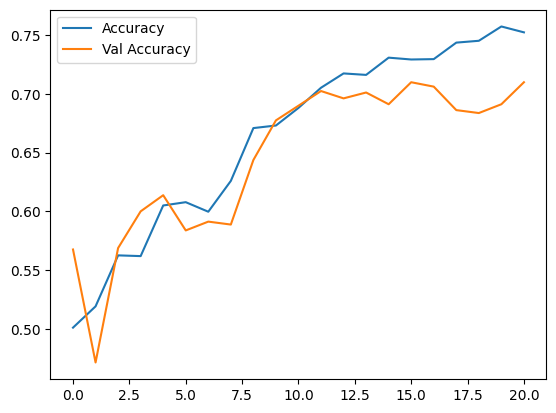

In [109]:
plt.plot(history_df['accuracy'],label='Accuracy')
plt.plot(history_df['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.show()

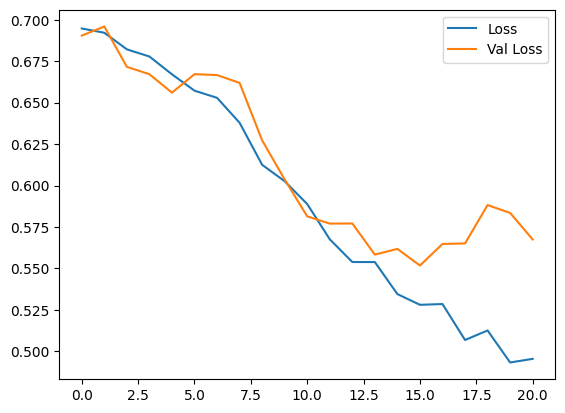

In [110]:
plt.plot(history_df['loss'],label='Loss')
plt.plot(history_df['val_loss'], label='Val Loss')
plt.legend()
plt.show()

---
Evaluate model

In [111]:
model.evaluate(X_test, y_test_num)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7258 - loss: 0.5526


[0.5457810759544373, 0.7350000143051147]

In [112]:
y_pred = [np.argmax(pred) for pred in model.predict(X_test)]

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step


In [113]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [114]:
unmap = {val:key for key,val in y_map.items()}

y_test_labels = [unmap[y] for y in y_test_num]
y_pred_labels = [unmap[y] for y in y_pred]

print(classification_report(y_test_labels, y_pred_labels))

              precision    recall  f1-score   support

         cat       0.72      0.77      0.74       500
         dog       0.75      0.70      0.72       500

    accuracy                           0.73      1000
   macro avg       0.74      0.73      0.73      1000
weighted avg       0.74      0.73      0.73      1000



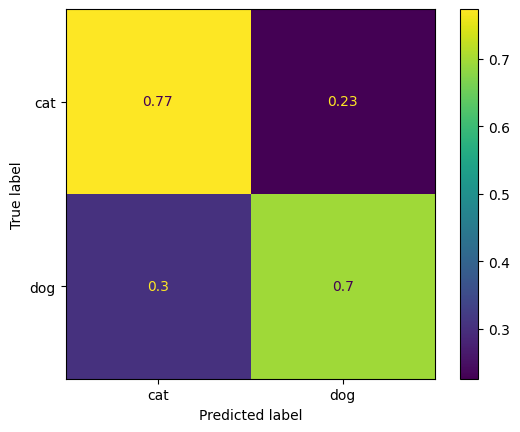

In [115]:
ConfusionMatrixDisplay.from_predictions(y_test_labels, y_pred_labels, normalize='true')

---
Visualizing errors and successes

In [116]:
confidence = [pred.max() for pred in model.predict(X_test)]
preds_df = pd.DataFrame({'True': y_test_labels, 'Predicted': y_pred_labels, 'Confidence': confidence})

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


In [117]:
error_preds = preds_df['True'] != preds_df['Predicted']
errors = preds_df[error_preds].sort_values('Confidence', ascending=False)
errors

,True,Predicted,Confidence
709,cat,dog,0.994347
177,dog,cat,0.978222
75,cat,dog,0.952995
834,cat,dog,0.940614
206,dog,cat,0.899763
...,...,...,...
220,cat,dog,0.509089
702,dog,cat,0.507844
648,dog,cat,0.507554
710,cat,dog,0.506681


In [118]:
for true_label, predicted_label in errors.iloc[0:10, 0:2].values:
    print(true_label, predicted_label)

cat dog
dog cat
cat dog
cat dog
dog cat
cat dog
dog cat
dog cat
dog cat
dog cat


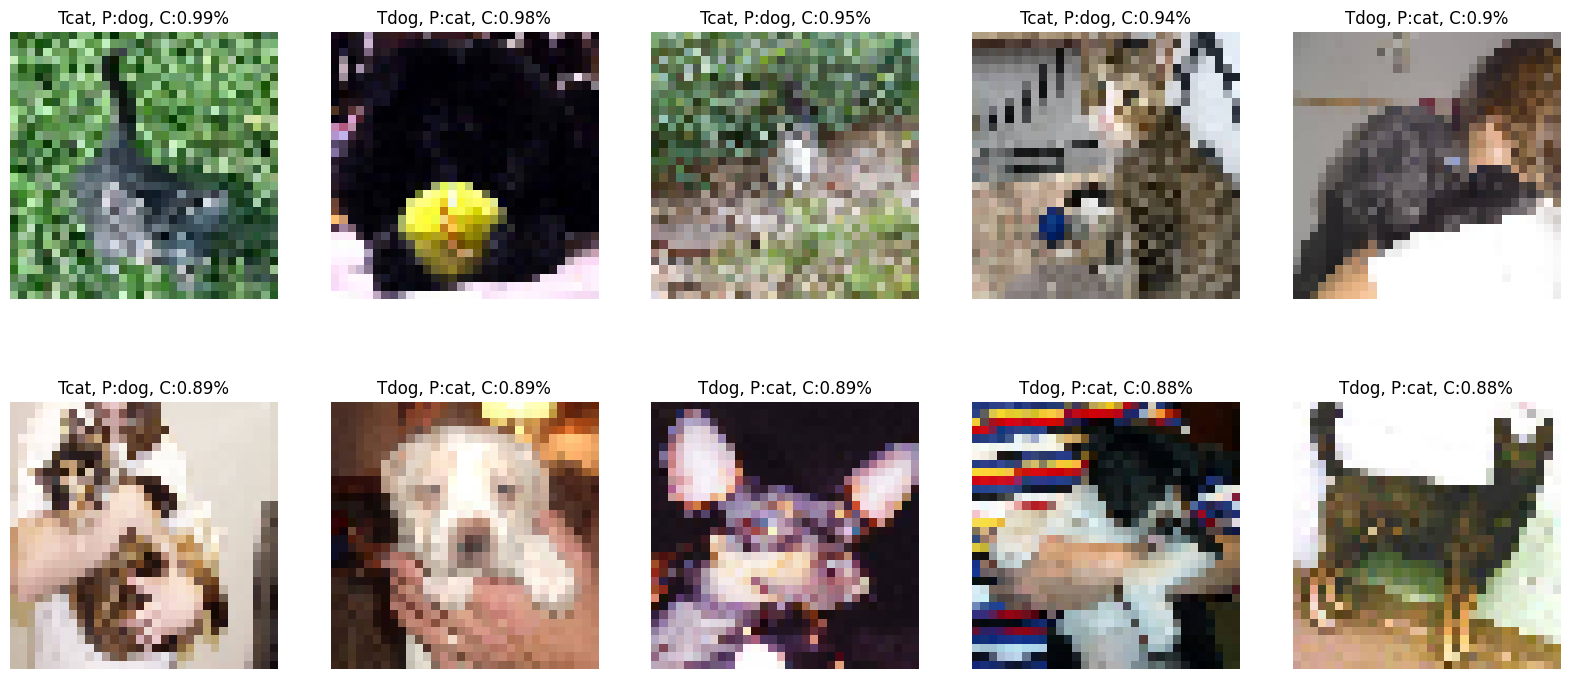

In [119]:
show_image_batch(X_test[errors.iloc[0:10].index], names=[f'T{val1}, P:{val2}, C:{round(val3,2)}%' for val1, val2, val3 in errors.iloc[0:10].values], size_scale=4)

In [120]:
dogs_as_cats = errors[(errors['True']=='dog')&(errors['Predicted']=='cat')].sort_values('Confidence', ascending=False)
cats_as_dogs = errors[(errors['True']=='cat')&(errors['Predicted']=='dog')].sort_values('Confidence', ascending=False)

In [121]:
dogs_as_cats_top10 = dogs_as_cats.head(int(len(dogs_as_cats) * 0.1))
cats_as_dogs_top10 = cats_as_dogs.head(int(len(dogs_as_cats) * 0.1))

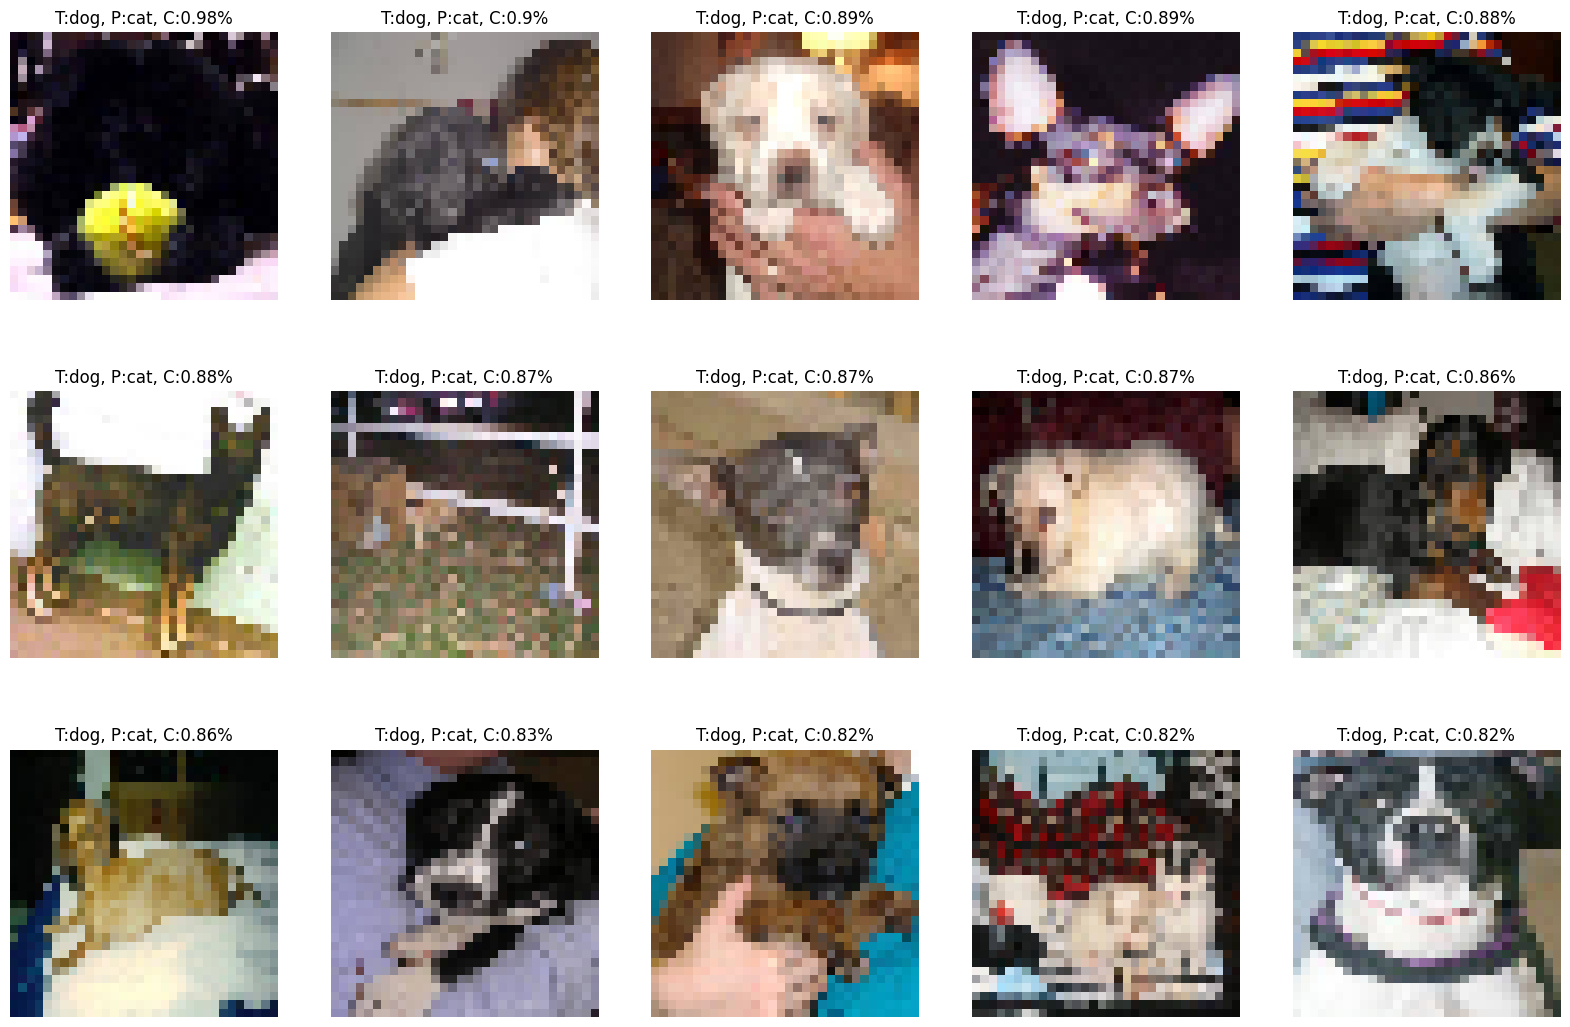

In [122]:
show_image_batch(X_test[dogs_as_cats_top10.index], names=[f'T:{val1}, P:{val2}, C:{round(val3,2)}%' for val1, val2, val3 in dogs_as_cats_top10.values], size_scale=4)

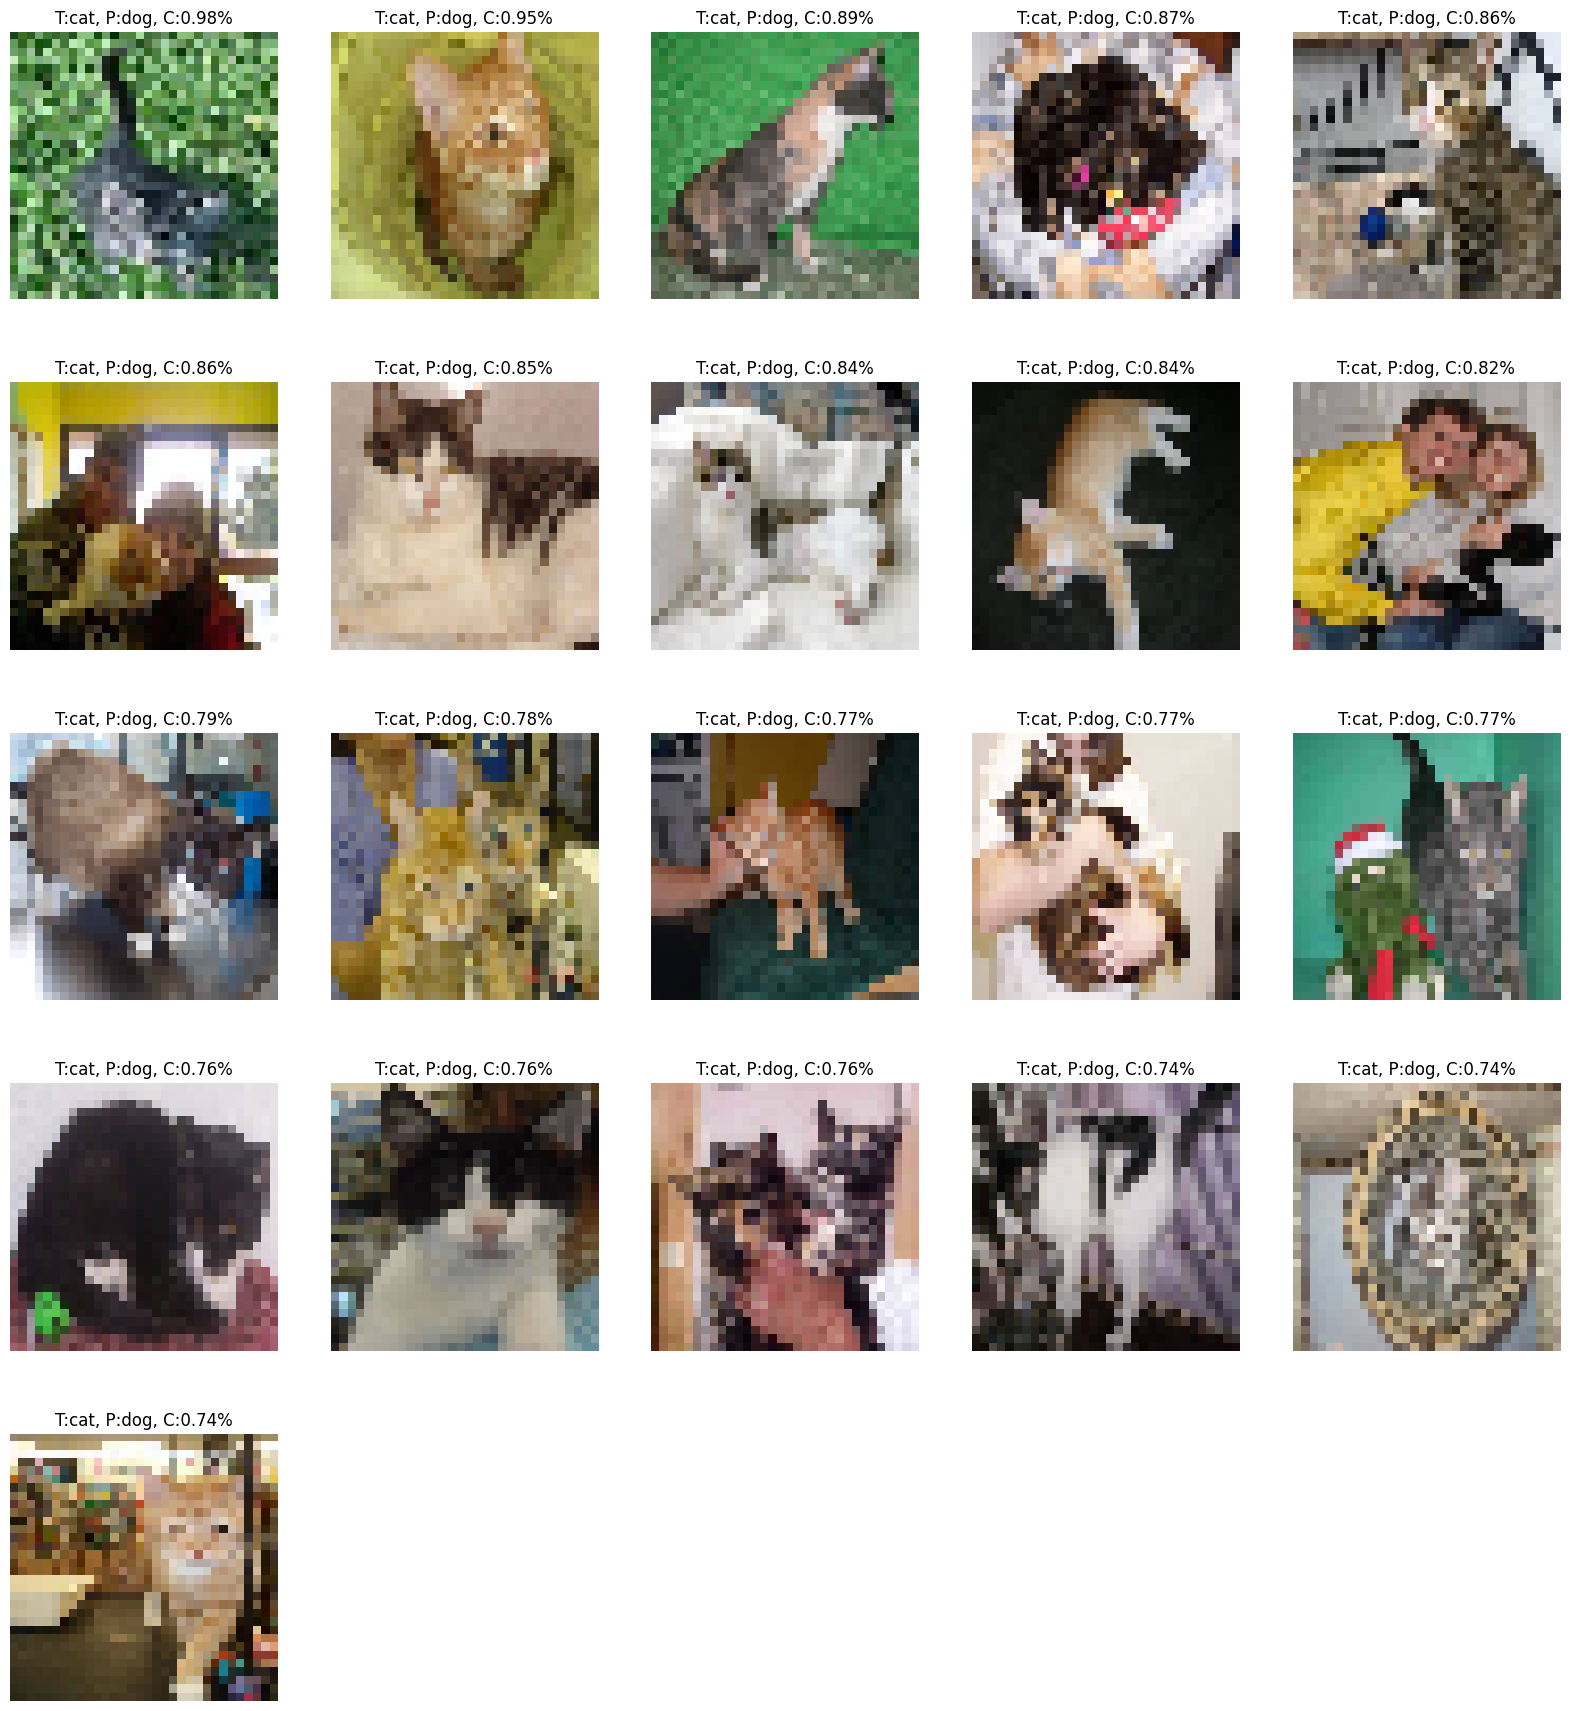

In [50]:
show_image_batch(X_test[cats_as_dogs_top10.index], names=[f'T:{val1}, P:{val2}, C:{round(val3,2)}%' for val1, val2, val3 in cats_as_dogs_top10.values], size_scale=4)